# **Avaliando reviews do GlassDoor utilizando NLP**

## Este notebook está subdividido em:

1.   Visualizando os comentários
2.   Word cloud com o comentários obtidos
3.   Filtrando os dados (adjetivos e substantivos)
4.   Nuvem de palavras dos principais adjetivos e substantivos
5.   Rankeamento das palavras filtradas
6.   Aspectos referentes aos comentários
7.   Identificando positividade dos aspectos

In [1]:
#Importar a biblioteca de visualização utilizada
import pandas as pd

#importar a biblioteca de nlp utilizada
import spacy
from spacy.matcher import DependencyMatcher

!python -m spacy download pt_core_news_sm
!python -m spacy download en_core_web_sm

#%pip install negspacy
from negspacy.termsets import termset
from negspacy.negation import Negex

#importar biblioteca de tradução
#%pip install googletrans==3.1.0a0
from googletrans import Translator

#remocao de acentos
from unicodedata import normalize

#Importar a bibliotecas:
#para geração do word cloud
from wordcloud import WordCloud
#para visualização dos graficos
import matplotlib.pyplot as plt
import seaborn as sns

#para anáilise de sentimentos
from textblob import TextBlob
#!python -m textblob.download_corpora

#para riqueza de vocabulário
from lexicalrichness import LexicalRichness

#Leitura de diretorio
import os

     ---------------------------------------- 22.2/22.2 MB 8.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')



[notice] A new release of pip available: 22.2.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 13.9/13.9 MB 8.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip available: 22.2.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#carregando o modulo com a linguagem selecionada
nlp_en = spacy.load('en_core_web_lg')
nlp_pt = spacy.load('pt_core_news_sm')

pt_stopwords = nlp_pt.Defaults.stop_words
en_stopwords = nlp_en.Defaults.stop_words

ts = termset('en')
nlp_en.add_pipe('negex',last=True, config={"neg_termset":ts.get_patterns()})

In [3]:
#Objeto para tradução
translator = Translator()

#Retorna um objeto da traducao ou entao uma lista de objetos, dependendo do parametro.
def traduzir_pt(text):
    traducao = translator.translate(text, dest='pt_br')

    return traducao

def normalizar_texto(text):
    text_norm = normalize('NFKD', text).encode('ASCII','ignore').decode('ASCII')
    text_norm = text_norm.lower()

    return text_norm

## Limpeza dos dados

Carregando e limpando o dataset, obtidos pelo scraper.

In [4]:
#Gerando as reviews em EN
data_path = "../Scraper/Liq/Liq-page344.csv"

In [5]:
def MergeDatasets():
    files = os.listdir('./ToMerge')

    df = pd.DataFrame({'pros':[], 'contras':[], 'rates': [], 'contras_en': [], 'pros_en': []})

    for file in files:
    #print(file)

        data = pd.read_csv('./ToMerge/'+file, index_col=[0])

        df = pd.concat([df, data], ignore_index=True)

        df.to_csv('./PTEN-'+data_path.split('/')[-2]+'.csv')

        df.head()
    
    return df

In [6]:
#Lendo dados já processados anteriormente
try:
  df = pd.read_csv('./PTEN-'+data_path.split('/')[-2]+'.csv', index_col=[0])

#Gerando novos dados
except:
  #Obter dados do arquivo csv
  df = pd.read_csv(data_path , index_col=[0])

  batchs_len = 2500
  index = 0
  len_df = len(df)

  while index < len_df:
    index_fim = index + batchs_len if index + batchs_len < len_df else index + (len_df % batchs_len)

    batch = df.iloc[ index:index_fim ]

    #Obter reviews positivas e negativas para traducao
    pros = [ x for x in batch['pros'].values ]
    contras = [ x for x in batch['contras'].values ]

    #Taduzir reviews
    translator = Translator()

    #Criar novas colunas
    batch['contras_en'] = [ x.text for x in translator.translate(contras) ]
    batch['pros_en'] = [ x.text for x in translator.translate(pros) ]

    #Salvar
    batch.to_csv('./ToMerge/PTEN-'+data_path.split('/')[-2]+str(index)+'.csv')

    index += batchs_len  

    print(f'Loading batch: {index}')  
  
  df = MergeDatasets()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3440 entries, 0 to 3439
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pros        3440 non-null   object
 1   contras     3440 non-null   object
 2   rates       3440 non-null   object
 3   contras_en  3440 non-null   object
 4   pros_en     3440 non-null   object
dtypes: object(5)
memory usage: 161.2+ KB


In [8]:
data = df.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3440 entries, 0 to 3439
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pros        3440 non-null   object
 1   contras     3440 non-null   object
 2   rates       3440 non-null   object
 3   contras_en  3440 non-null   object
 4   pros_en     3440 non-null   object
dtypes: object(5)
memory usage: 161.2+ KB


Riqueza de vocabulário presente na reviews

In [9]:
#Calculando o ttr
ttr_pros = []

for x in data['pros_en']:
    try:
        ttr = float(LexicalRichness(x).cttr)
        ttr_pros.append(ttr)
    
    except:
        ttr_pros.append(0)

ttr_contra = []

for x in data['contras_en']:
    try:
        ttr = float(LexicalRichness(x).cttr)
        ttr_contra.append(ttr)
    
    except:
        ttr_contra.append(0)

data['ttr_pros'] = ttr_pros
data['ttr_contra'] = ttr_contra
data['ttr_medio'] = (data['ttr_pros'] + data['ttr_contra']) / 2

#Normalizando o ttr_medio
amin, amax = data['ttr_medio'].min(), data['ttr_medio'].max()
data['ttr_normalized'] = [ (x-amin) / (amax-amin) for x in data['ttr_medio'] ] 

In [10]:
filt = data['ttr_normalized'] < 0.17

data[filt]

,pros,contras,rates,contras_en,pros_en,ttr_pros,ttr_contra,ttr_medio,ttr_normalized
9,paga em dia atualmente a a a,imprevisível a a a a a,"4,0",unpredictable a a a a a,currently pays up to date,1.581139,0.577350,1.079245,0.142751
10,Experiência . . . .,Irresponsabilidade . . . . .,"3,0",Irresponsibility. . . . .,Experience . . . .,0.707107,0.707107,0.707107,0.071383
60,Boa experiencia como primeiro emprego.,"Salario minimo, salario, salario, salario, sal...","3,0","Minimum wage, wage, wage, wage, wage",Good experience as a first job.,1.732051,0.577350,1.154701,0.157222
61,Amizade Amizade Amizade Amizade Amizade,Tudo Tudo Tudo Tudo Tudo,"1,0",Everything Everything Everything Everything,friendship friendship friendship friendship fr...,0.316228,0.353553,0.334891,0.000000
128,"Excelente empresa, ótimo turno e salário","Nenhuma, nenhuma nenhuma nenhuma nenhuma","5,0","None, none none none none","Great company, great shift and salary",1.443376,0.316228,0.879802,0.104502
280,Crescimento reconhecimento \nDurabilidade \nCr...,Nada a declarar\nNada a declarar \nNada a decl...,"4,0",nothing to declare\nnothing to declare\nnothin...,growth recognition\nDurability\nCreativity\nCl...,1.732051,0.612372,1.172212,0.160580
329,"Atrasa o salario , Atrasa o salario,Atrasa o s...",Nao paga a hora extra,"3,0",Doesn't pay overtime,"Delayed salary, Delayed salary, Delayed salary...",0.500000,1.414214,0.957107,0.119328
342,Sem prós Sem prós Sem prós,"Local de trabalho, salário atrasado, atrasa pa...","1,0","Workplace, delayed salary, delay passage. Unor...",No Pros No Pros No Pros,0.577350,1.732051,1.154701,0.157222
675,Ótima boa boa boa boa,Nada nada nada nada nada,"3,0",nothing nothing nothing nothing nothing,great good good good good,0.632456,0.316228,0.474342,0.026744
753,"Assistência médica, odontológica, vale aliment...",Salário baixo etc etc etc,"4,0",Low salary etc etc etc,"Medical, dental, food allowance.",1.414214,0.948683,1.181448,0.162352


In [11]:
data = data.drop(index=data[filt].index)

In [12]:
data

,pros,contras,rates,contras_en,pros_en,ttr_pros,ttr_contra,ttr_medio,ttr_normalized
0,"Salário pago sempre em dia, ótimos benefícios ...",Dificuldade em troca de turno.,"5,0",Difficulty in shift change.,"Salary paid on time, great benefits and opport...",2.236068,1.414214,1.825141,0.285798
1,Apenas 6 horas de serviço. Paga sempre na data...,Tem que passar por todo um stress pra consegui...,"5,0",You have to go through all the stress to be ab...,Only 6 hours of service. Always pay on the due...,2.236068,4.385928,3.310998,0.570754
2,A empresa te dá a chance de escolher o horário...,"Nada do que reclamar da liq. Ao contrário, só ...","5,0",Nothing to complain about liq. On the contrary...,The company gives you the chance to choose the...,2.886751,2.651650,2.769201,0.466849
3,Dar oportunidade de crescer na empresa,Surpervisores que gosta de oprimir o funcionario,"4,0",Supervisors who like to oppress the employee,Give opportunity to grow in the company,1.870829,1.870829,1.870829,0.294560
4,"Área de descontração, alimentação, local bem h...","Barulho no local de trabalho, fofocas.","4,0","Noise in the workplace, gossip.","Relaxation area, food, very hygienic place.",1.732051,1.581139,1.656595,0.253475
...,...,...,...,...,...,...,...,...,...
3435,Possui plano de saúde com padrões acima de out...,Por ser muito grande às vezes os processos e t...,"4,0","Because it is very large, sometimes the proces...",It has a health plan with standards above othe...,3.340766,4.142586,3.741676,0.653349
3436,"Experiência que levarei por toda vida, por tud...","mal remuneração, mal qualificação dos gestores...","2,0","poor remuneration, poor qualification of manag...",An experience that I will take with me for a l...,3.250000,2.041241,2.645621,0.443149
3437,sinto uma certa estilidade e segurança referen...,empresa que prega relacionamentos e comunicaça...,"2,0",company that preaches relationships and commun...,I feel a certain stability and security regard...,2.572479,2.969848,2.771164,0.467226
3438,paga em dia,"desconta demais, é muito desorganizada , onda ...","1,0","too much discount, very disorganized, where su...",pay on time,1.224745,3.240370,2.232558,0.363932


## Word clouds

###   Pre-processamento do texto e coleta dos substantivos presentes

Visto a vasta gama de palavras, iremos filtrar por substantivos para um melhor entendimento.

In [13]:
#texto pre-preprocessado
p_text = ''

#substantivos
substantivos = []

for review in data['pros']:
    #tokenizando
    doc = nlp_pt(review)

    for tk in doc:
        #Removendo pontuacoes
        if not tk.is_punct:
            #Stopwords
            if not tk.is_stop:
                #Espaços
                if not tk.is_space:
                    #Digítos
                    if not tk.is_digit:
                        #Dinheiro
                        if tk.text.find('$') == -1 and tk.text.find(',') == -1:
                            p_text += normalizar_texto(tk.lemma_) + ' '

                            if tk.pos_ == 'NOUN':
                                substantivos.append(normalizar_texto(tk.lemma_))

for review in data['contras']:
    #tokenizando
    doc = nlp_pt(review)

    for tk in doc:
        #Removendo pontuacoes
        if not tk.is_punct:
            #Stopwords
            if not tk.is_stop:
                #Espaços
                if not tk.is_space:
                    #Digítos
                    if not tk.is_digit:
                        #Dinheiro
                        if tk.text.find('$') == -1 and tk.text.find(',') == -1:
                            p_text += normalizar_texto(tk.lemma_) + ' '

                            if tk.pos_ == 'NOUN':
                                substantivos.append(normalizar_texto(tk.lemma_))

### Word Cloud com todas a palavras

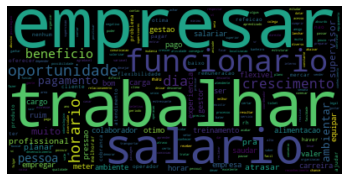

In [14]:
# Gerar a imagem da nuvem de palavras
wordcloud = WordCloud(collocations=False, max_font_size=100).generate(p_text)

fig = plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

fig.savefig("../Dashboard/assets/words.svg", bbox_inches='tight', pad_inches=0, dpi=1000.0)

### Nuvem de substantivos

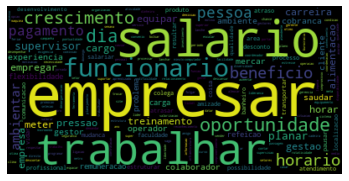

In [15]:
# Gerar a imagem da nuvem de palavras para substantivos
wordcloud = WordCloud(collocations=False).generate( ' '.join(substantivos) )

fig = plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.show()

# Save the graphc
fig.savefig("../Dashboard/assets/subs.png", bbox_inches='tight', pad_inches= 0,format='png',dpi=1000)

## Rankeamento das palavras filtradas

Dando sequencia, será apresentado o rankeamento dos adjetivos e substantivos.


### Adjetivos

In [16]:
# #Transformar em dataframe
# dataset_adj = pd.DataFrame(adjetivos)

# #Rankear os adjetivos e pegar os 10 mais frequentes
# top_adjs = dataset_adj.value_counts().head(20)

In [17]:
# #Obter adjetivos e sua frequência
# keys = [ x[0] for x in top_adjs.keys() ]
# values = top_adjs.values

# # Create bars
# fig =plt.figure(figsize = (25,10))
# plt.bar(keys, values)

# # Show graphic
# plt.show()

# # Save the graphic
# fig.savefig('../Dashboard/assets/topadjs.png', bbox_inches='tight',pad_inches=0,format='png',dpi=300)

In [18]:
# #Armazernar os adjetivos
# adjs = []

# #Obter os adjetivos
# for adj, count in zip(top_adjs.keys(), top_adjs.values):
#   for i in range(count):
#     adjs.append(adj[0])

# # Gerar a imagem da nuvem de palavras para adjetivos
# wordcloud = WordCloud().generate( to_text(adjs) )

# plt.figure(figsize=(20,20))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

### Substantivos

In [19]:
#Transformar em dataframe
dataset_subs = pd.DataFrame(substantivos)

#Rankear os adjetivos e pegar os 10 mais frequentes
top_subs = dataset_subs.value_counts().head(10)

#Armazernar os adjetivos
subs = []

#Obter os adjetivos
for adj, count in zip(top_subs.keys(), top_subs.values):
  for i in range(count):
    subs.append(adj[0])

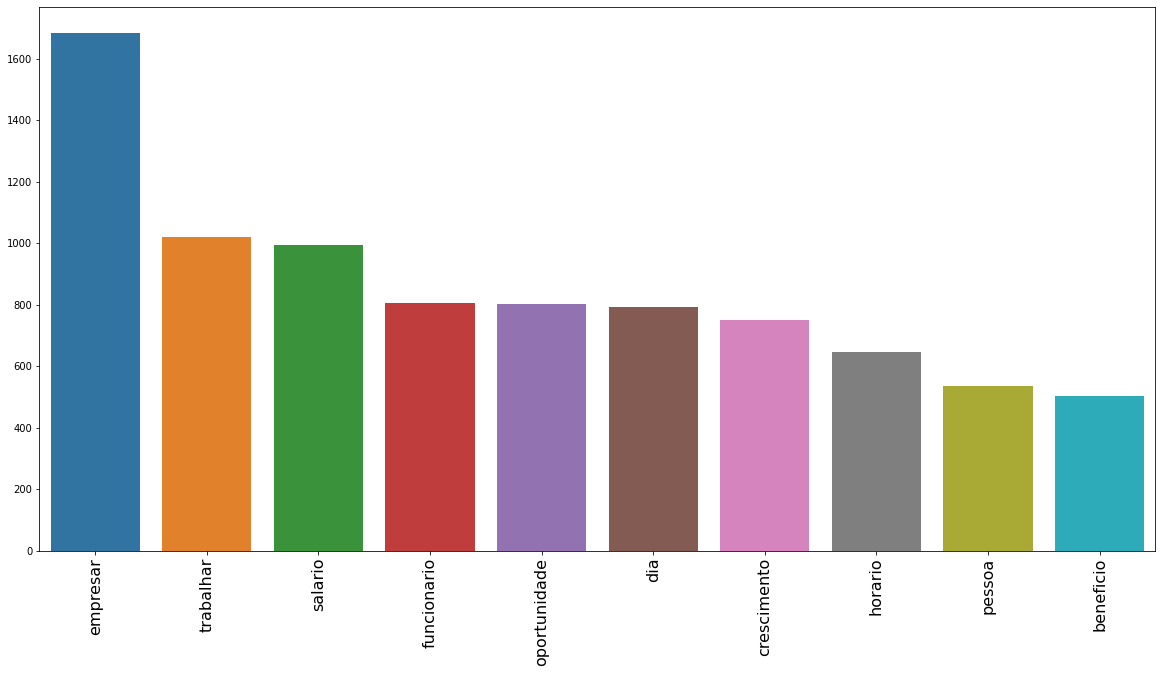

In [20]:
#Obter sujetivos e sua frequência
keys = [ x[0] for x in top_subs.keys() ]
values = top_subs.values

# Create bars
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x = keys, y = values, ax = ax)

# Show graphic
plt.xticks(rotation=90,fontsize=16)
plt.show()

# Save the graphic
fig.savefig('../Dashboard/assets/topsubs.png', bbox_inches='tight',pad_inches=0,format='png',dpi=1000)

In [21]:
# # Gerar a imagem da nuvem de palavras para subjetivos
# wordcloud = WordCloud().generate( to_text(subs) )

# plt.figure(figsize=(20,20))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

### Aspectos referentes aos comentários

Nesta seção cada comentário será analisado a fim de se obter o apecto e a descrição do mesmo, em cada frase presente em um comentário.

In [22]:
#Obter comentários
pros_comments = [ x for x in data["pros_en"].values ]
cons_comments = [ x for x in data["contras_en"].values ]

pattern = [{"RIGHT_ID": "target", "RIGHT_ATTRS": {"POS": "NOUN"}},{"LEFT_ID": "target", "REL_OP": ">", "RIGHT_ID": "modifier", "RIGHT_ATTRS":{"DEP": {"IN": ["amod", "nummod"]}}},]

#Armazenar os aspectos
aspects = []

matcher = DependencyMatcher(nlp_en.vocab)
matcher.add("FOUNDED",[pattern])

#Avaliar cada comentário pros
for comentario in pros_comments:
  doc = nlp_en(comentario)

  for match_id, (target,modifier) in matcher(doc):
      if(doc[modifier].pos_ == 'ADJ'):
        prepend = ''

        for child in doc[modifier].children:
          if child.pos_ != 'ADJ' and child.text != 'not':
              continue
          prepend += child.lemma_.lower() + ''

        descriptive_term = prepend + doc[modifier].lemma_.lower()

        if((doc[modifier].text,True) in [(e.text,e._.negex) for e in doc.ents]):
          descriptive_term = 'not ' + descriptive_term
        
        aspects.append({'aspect': doc[target].lemma_.lower(),'description':descriptive_term,'review': comentario, 'ttr' : data[data.pros_en == comentario]['ttr_pros'].values[0]})

#Avaliar cada comentário contras
for comentario in cons_comments:
  doc = nlp_en(comentario)

  for match_id, (target,modifier) in matcher(doc):
      if(doc[modifier].pos_ == 'ADJ'):
        prepend = ''

        for child in doc[modifier].children:
          if child.pos_ != 'ADJ' and child.text != 'not':
              continue
          prepend += child.lemma_.lower() + ''

        descriptive_term = prepend + doc[modifier].lemma_.lower()

        if((doc[modifier].text,True) in [(e.text,e._.negex) for e in doc.ents]):
          descriptive_term = 'not ' + descriptive_term
        
        aspects.append({'aspect': doc[target].lemma_.lower(),'description':descriptive_term,'review': comentario,'ttr' : data[data.contras_en == comentario]['ttr_contra'].values[0]})

# for aspect in aspects:
#   print(aspect)


### Identificando positividade dos aspectos

Após a identificação dos aspectos, analisaremos se dado circunstancia o aspecto foi analisado positivamente ou negativamente

In [23]:
#iniciar tradutor
#translator = Translator(to_lang="en", from_lang='pt')

#avaliar cada aspecto
for aspect in aspects:
  description = aspect['description']
  #translation = translator.translate(description)
  
  sentiment = TextBlob(description).sentiment
  aspect['polarity'] = sentiment.polarity
  aspect['subjectivity'] = sentiment.subjectivity

In [24]:
#exibir aspectos identificados
# aspects_analyze = []
# for aspect in aspects:  
#   if aspect['polarity'] > 0.0:
#     aspects_analyze.append( (aspect['aspect'] + " " + aspect['description'], "positivo") )
#   elif aspect['polarity'] < 0.0:
#     aspects_analyze.append( (aspect['aspect'] + " " + aspect['description'], "negativo") )
#   else:
#     aspects_analyze.append( (aspect['aspect'] + " " + aspect['description'], "neutro") )

# for item in aspects_analyze:
#   print(item)

In [25]:
#Exibir aspectos obtidos
df_aspects = pd.DataFrame(aspects)

#Filtrar polaridade
df_negative_aspects = df_aspects[df_aspects.polarity < -0.4]
df_positive_aspects = df_aspects[df_aspects.polarity > 0.4]

#df_neutral_aspects = df_aspects[df_aspects.polarity >= -0.4]
#df_neutral_aspects = df_neutral_aspects[df_neutral_aspects.polarity <= 0.4]

df_negative_aspects

,aspect,description,review,ttr,polarity,subjectivity
25,company,terrible,"None, terrible company to work for",1.732051,-1.000000,1.000000
30,commitment,terrible,"Terrible to pay, no commitment to employees",1.603567,-1.000000,1.000000
42,supervisor,horrible,Low pay horrible supervisors bad coordination,1.732051,-1.000000,1.000000
43,coordination,bad,Low pay horrible supervisors bad coordination,1.732051,-0.700000,0.666667
69,company,bad,None nothing nothing bad company,1.264911,-0.700000,0.666667
...,...,...,...,...,...,...
9138,goal,impossible,"It is a dirty looking company, lacks hygiene i...",4.110961,-0.666667,1.000000
9155,management,bad,Bad management. An incompetent and messy hr. D...,2.236068,-0.700000,0.666667
9161,environment,filthy,Pressure to achieve goals that will be impossi...,2.864358,-0.800000,1.000000
9162,eye,blind,turning a blind eye to some cases of bad behav...,3.585686,-0.500000,0.666667


C:\Users\eduar\AppData\Local\Temp\ipykernel_9048\70165410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negative_aspects['asp-desc'] = [ str(y) + ' ' + str(x) for x,y in zip( df_negative_aspects['aspect'], df_negative_aspects['description'] )]


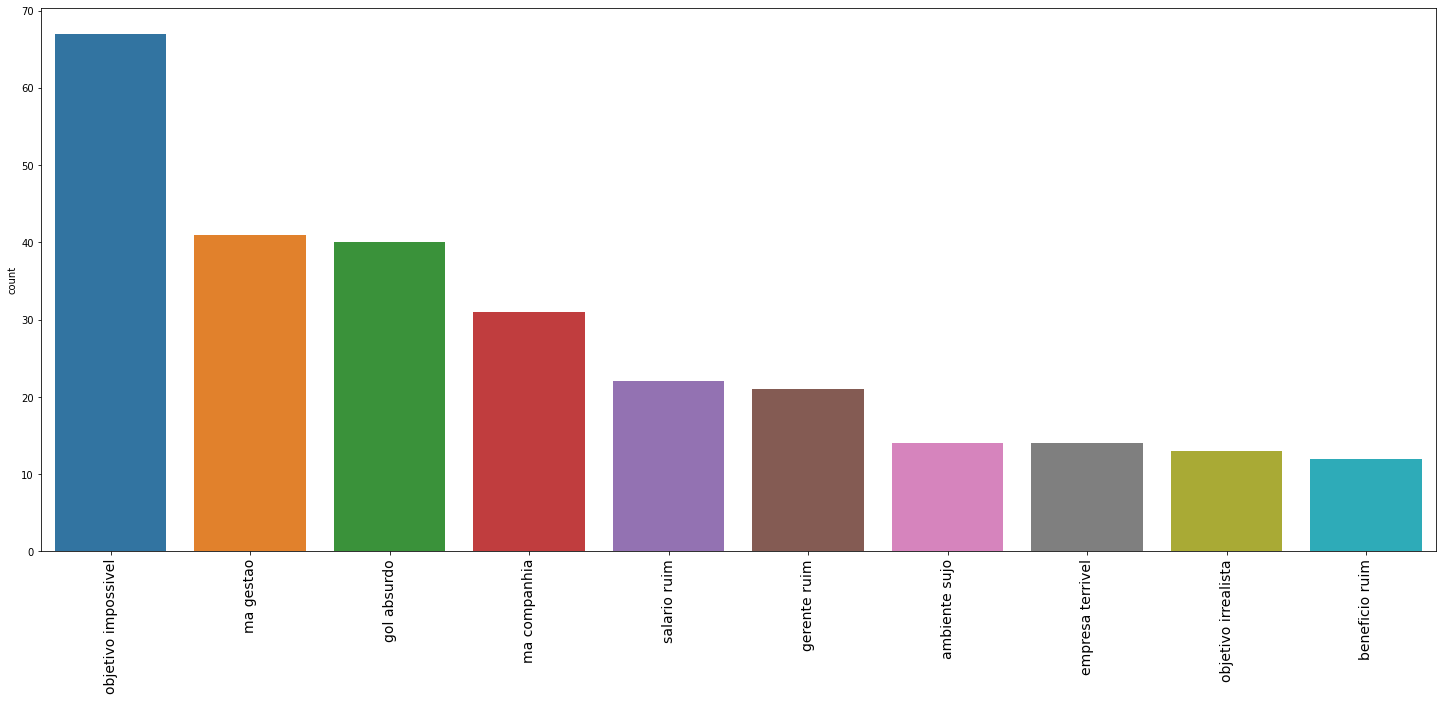

In [26]:
df_negative_aspects['asp-desc'] = [ str(y) + ' ' + str(x) for x,y in zip( df_negative_aspects['aspect'], df_negative_aspects['description'] )]

ranking_negative = df_negative_aspects.value_counts('asp-desc')

keys = ranking_negative.index

embedded_n = {}

for key in keys:    
    for emb in embedded_n:
        if emb.split(' ')[1] == key.split(' ')[1]:
            s1 = nlp_en(key)
            s2 = nlp_en(emb)

            if s1.similarity(s2) >= 0.80:
                embedded_n[emb] += ranking_negative[key]

    else:
        embedded_n[key]= ranking_negative[key]

new_df = pd.DataFrame( { 'asp-desc': embedded_n.keys(), 'count': embedded_n.values() } )

new_df.sort_values(by='count',inplace=True, ascending=False)

new_df = new_df.head(10)

fig, ax = plt.subplots(figsize=(25,10))

sns.barplot(x = [normalizar_texto(x.text) for x in traduzir_pt(list(new_df['asp-desc']))], y = new_df['count'], ax = ax)
plt.xticks(rotation=90,fontsize=14)
plt.show()

fig.savefig("../Dashboard/assets/negAspDesc.png", bbox_inches='tight',pad_inches=0,format='png',dpi=1000)


C:\Users\eduar\AppData\Local\Temp\ipykernel_9048\3705931188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive_aspects['asp-desc'] = [ str(y) + ' ' + str(x) for x,y in zip( df_positive_aspects['aspect'], df_positive_aspects['description'] )]


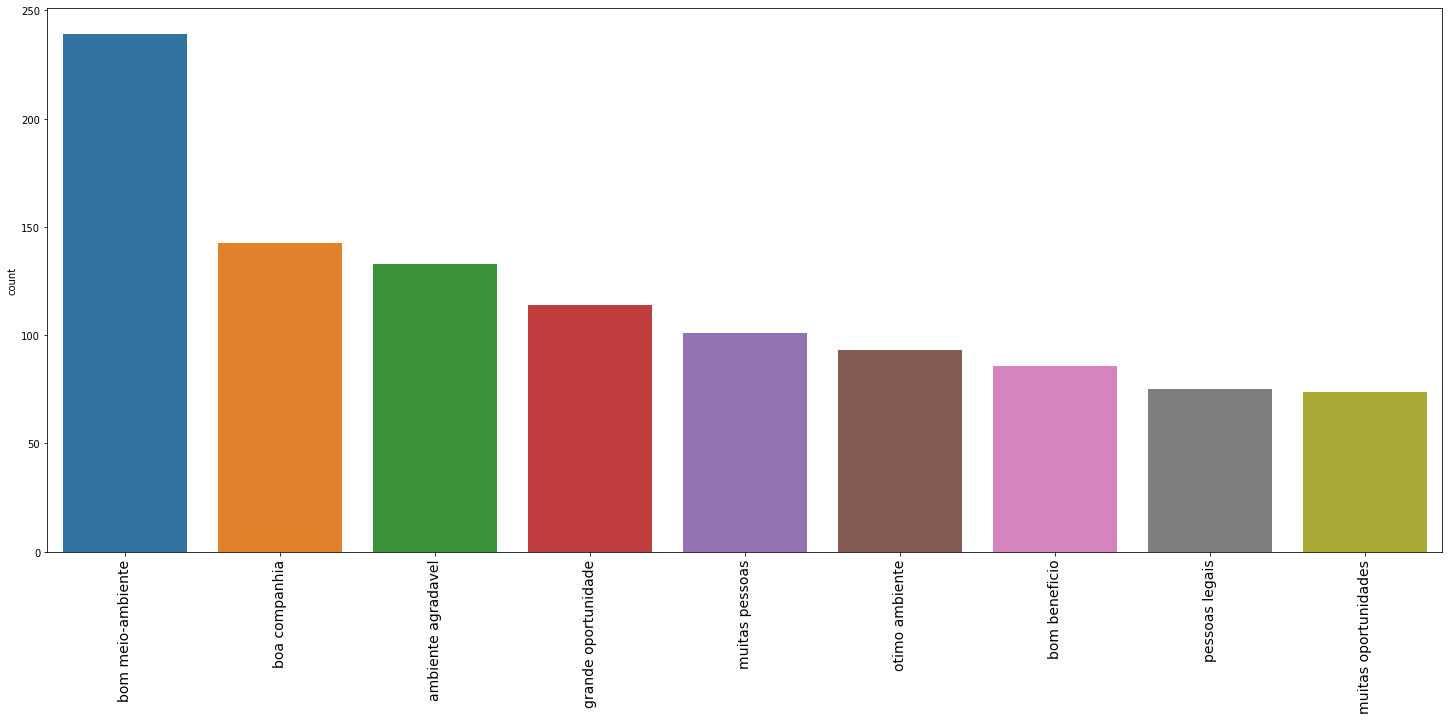

In [27]:
df_positive_aspects['asp-desc'] = [ str(y) + ' ' + str(x) for x,y in zip( df_positive_aspects['aspect'], df_positive_aspects['description'] )]

ranking_positive = df_positive_aspects.value_counts('asp-desc')

keys = ranking_positive.index

embedded_p = {}

for key in keys:    
    for emb in embedded_p:
        if emb.split(' ')[1] == key.split(' ')[1]:
            s1 = nlp_en(key)
            s2 = nlp_en(emb)

            if s1.similarity(s2) >= 0.80:
                embedded_p[emb] += ranking_positive[key]

    else:
        embedded_p[key]= ranking_positive[key]

new_df = pd.DataFrame( { 'asp-desc': embedded_p.keys(), 'count': embedded_p.values() } )

new_df.sort_values(by='count',inplace=True, ascending=False)

new_df = new_df.head(10)

fig, ax = plt.subplots(figsize=(25,10))

sns.barplot(x = [ normalizar_texto(x.text) for x in traduzir_pt(list(new_df['asp-desc']))], y = new_df['count'], ax = ax, errorbar=None)

plt.xticks(rotation=90,fontsize=14)
plt.show()

fig.savefig("../Dashboard/assets/posAspDesc.png", bbox_inches='tight',pad_inches=0,format='png',dpi=1000)

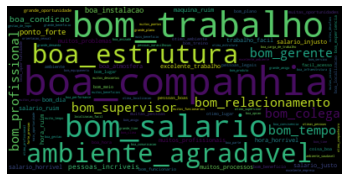

In [28]:
#Armazernar os adjetivos
adjs = []

#Obter os adjetivos
for adj, count in zip(embedded_p.keys(), embedded_p.values()):  
  traducao = traduzir_pt(adj)
  norm = normalizar_texto(traducao.text)
  
  adjs.append(str(norm).replace(' ','_').strip())

for adj, count in zip(embedded_n.keys(), embedded_n.values()):
  traducao = traduzir_pt(adj)
  norm = normalizar_texto(traducao.text)
  
  adjs.append(str(norm).replace(' ','_').strip())

# Gerar a imagem da nuvem de palavras para adjetivos
wordcloud = WordCloud(collocations=False).generate( ' '.join(adjs) )

fig = plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Save the graphc
fig.savefig("../Dashboard/assets/adjs.png", bbox_inches='tight',pad_inches=0,format='png',dpi=1000)

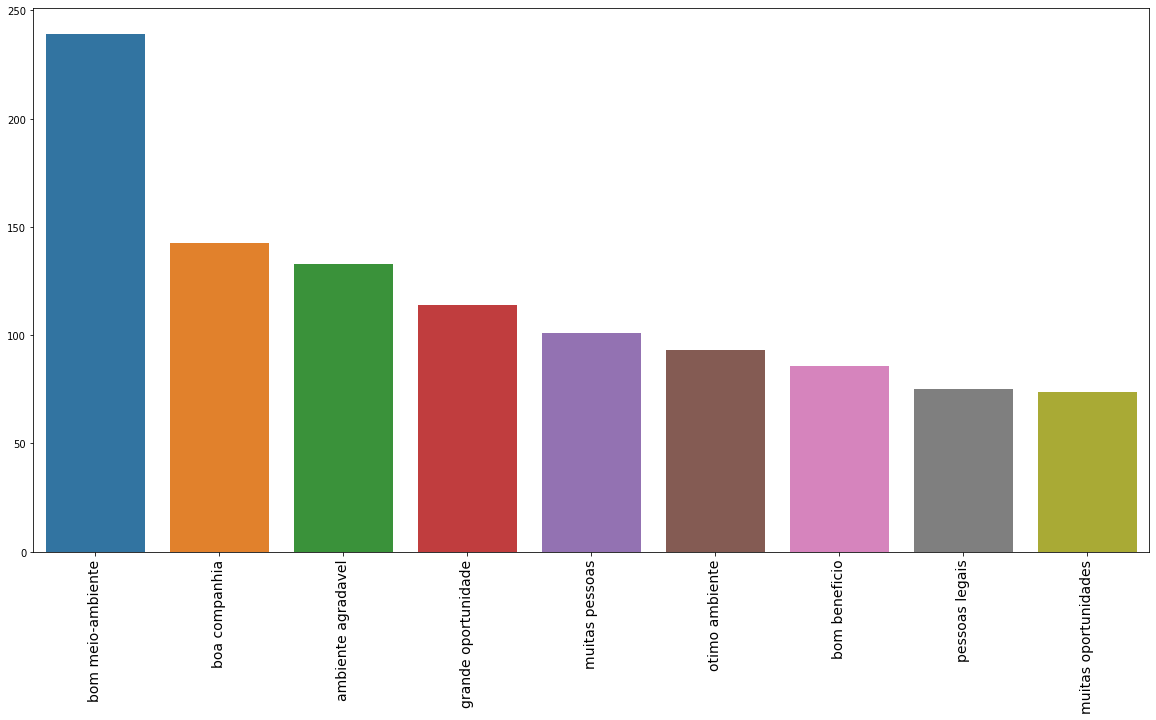

In [29]:
adjs_p = pd.DataFrame( {'asp_desc': embedded_p.keys(), 'count': embedded_p.values()} )
adjs_n = pd.DataFrame( {'asp_desc': embedded_n.keys(), 'count': embedded_n.values()} )

df_adjs = pd.concat([adjs_p, adjs_n], ignore_index=True)
tops_adjs = df_adjs.sort_values('count', ascending=False).head(10)

keys = [ x for x in tops_adjs['asp_desc'].values[0:10]]
values = tops_adjs['count'].values[0:10]

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(x = [normalizar_texto(x.text) for x in traduzir_pt(keys)],y = values, ax = ax, errorbar=None)
plt.xticks(rotation=90,fontsize=14)
plt.show()

fig.savefig("../Dashboard/assets/topAdjs.png", bbox_inches='tight',pad_inches=0,format='png',dpi=1000)

In [30]:
df_negative_aspects

,aspect,description,review,ttr,polarity,subjectivity,asp-desc
25,company,terrible,"None, terrible company to work for",1.732051,-1.000000,1.000000,terrible company
30,commitment,terrible,"Terrible to pay, no commitment to employees",1.603567,-1.000000,1.000000,terrible commitment
42,supervisor,horrible,Low pay horrible supervisors bad coordination,1.732051,-1.000000,1.000000,horrible supervisor
43,coordination,bad,Low pay horrible supervisors bad coordination,1.732051,-0.700000,0.666667,bad coordination
69,company,bad,None nothing nothing bad company,1.264911,-0.700000,0.666667,bad company
...,...,...,...,...,...,...,...
9138,goal,impossible,"It is a dirty looking company, lacks hygiene i...",4.110961,-0.666667,1.000000,impossible goal
9155,management,bad,Bad management. An incompetent and messy hr. D...,2.236068,-0.700000,0.666667,bad management
9161,environment,filthy,Pressure to achieve goals that will be impossi...,2.864358,-0.800000,1.000000,filthy environment
9162,eye,blind,turning a blind eye to some cases of bad behav...,3.585686,-0.500000,0.666667,blind eye


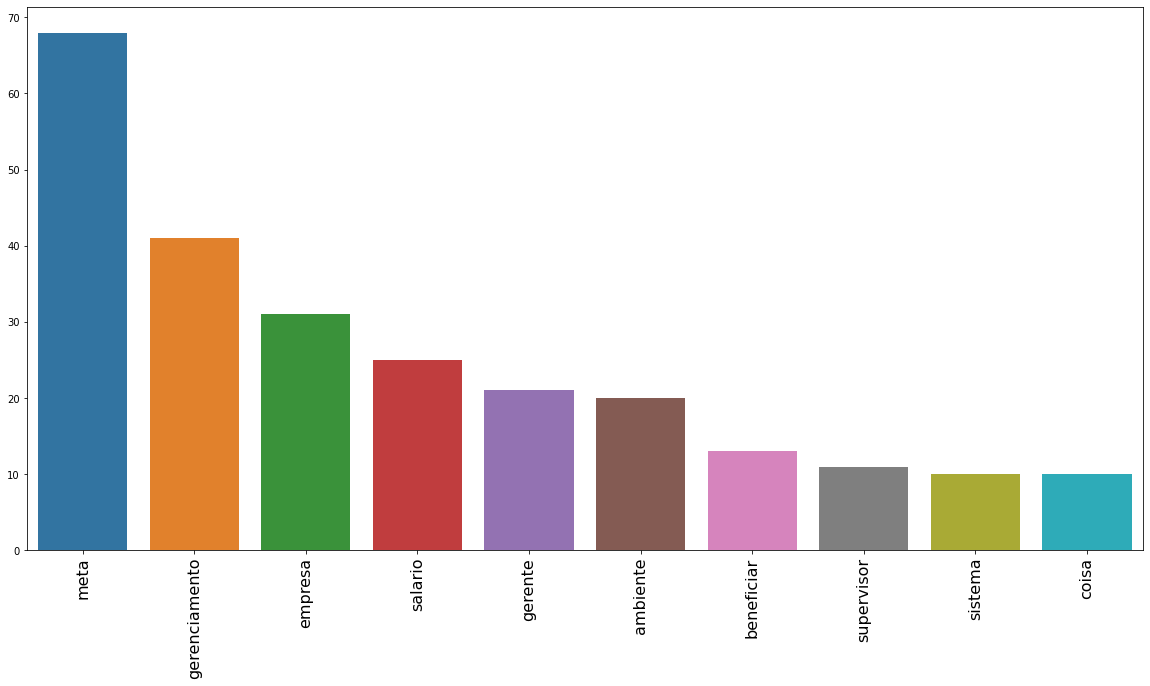

In [31]:
top10_negative = df_negative_aspects.value_counts('aspect').head(10)

keys = [x for x in top10_negative.keys()]
values = top10_negative.values

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot( x = [normalizar_texto(x.text) for x in traduzir_pt(keys)], y = values, ax = ax)
plt.xticks(rotation=90,fontsize=16)
plt.show()

fig.savefig("../Dashboard/assets/negAsp.png", bbox_inches='tight',pad_inches=0,format='png',dpi=1000)

#Melhor review com cada aspecto do top 10

reviews = []

for key in keys:
    filt = df_negative_aspects['aspect'] == key

    review = df_negative_aspects[filt].sort_values('ttr', ascending=False)['review'].head(1).values[0]    

    rich_review = traduzir_pt(review).text
    
    reviews.append(str(rich_review))

file = open('../Dashboard/assets/negAspReviews.txt', 'w')

for review in reviews:
    file.write(review.encode('cp850','replace').decode('cp850') + '\n')

file.close()

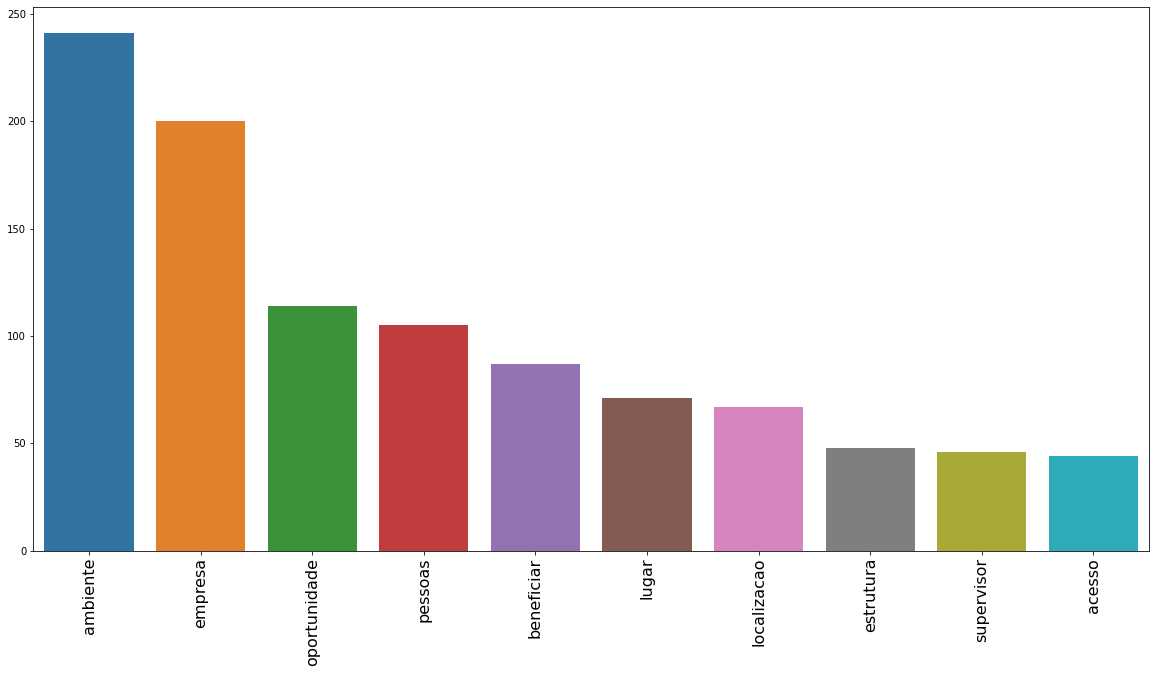

In [32]:
top10_positive = df_positive_aspects.value_counts('aspect').head(10)

keys = [x for x in top10_positive.keys()]
values = top10_positive.values

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(x = [normalizar_texto(x.text) for x in traduzir_pt(keys)], y = values, ax = ax)
plt.xticks(rotation=90,fontsize=16)
plt.show()

fig.savefig("../Dashboard/assets/posAsp.png", bbox_inches='tight',pad_inches=0,format='png',dpi=1000)

#Melhor review com cada aspecto do top 10

reviews = []

for key in keys:
    filt = df_positive_aspects['aspect'] == key

    review = df_positive_aspects[filt].sort_values('ttr', ascending=False)['review'].head(1).values[0]    

    rich_review = traduzir_pt(review).text
    
    reviews.append(str(rich_review))

file = open('../Dashboard/assets/posAspReviews.txt', 'w')

for review in reviews:
    file.write(review.encode('cp850','replace').decode('cp850') + '\n')

file.close()

In [33]:
# top10_neutral = df_neutral_aspects.value_counts('aspect').head(10)

# keys = top10_neutral.keys()
# values = top10_neutral.values

# fig, ax = plt.subplots(figsize=(20,10))

# ax.bar(keys,values)
# plt.show()

## Rankeamento baseado no fator definido por:

(Frequencia / toltal) * Média(polaridade)

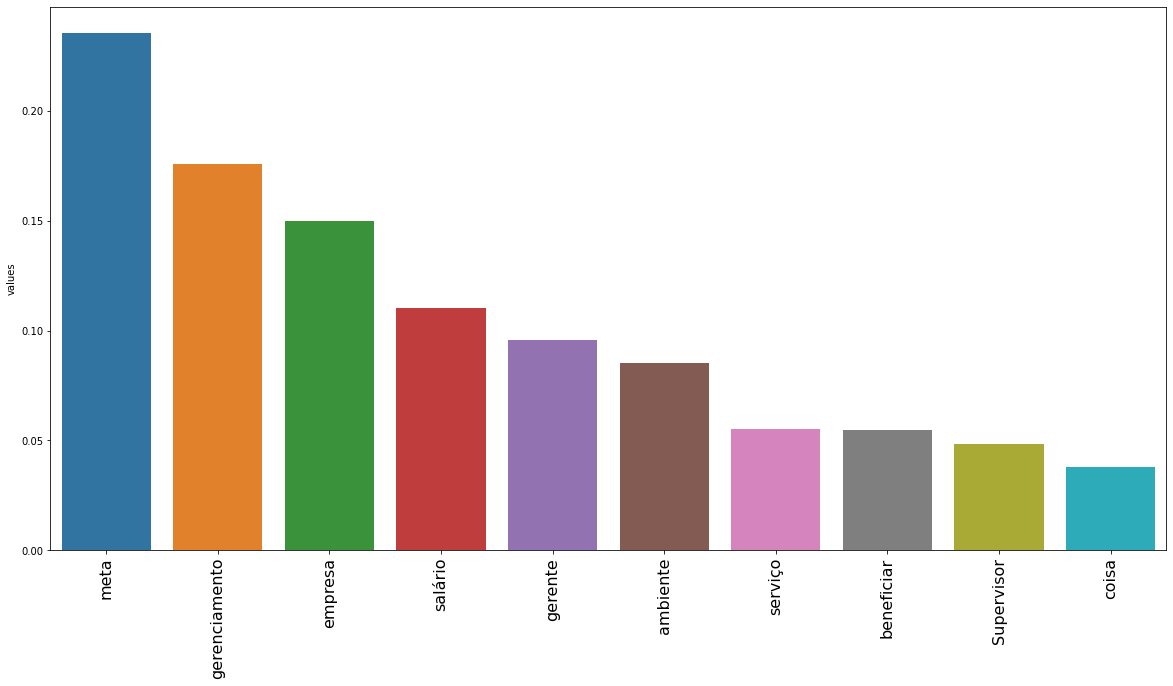

In [34]:
#Rankeamento dos aspectos negativos
freq_aspects = df_negative_aspects.value_counts('aspect')
total = len(df_negative_aspects.value_counts('aspect'))

polarity_means = df_negative_aspects[['aspect','polarity']].groupby('aspect').mean()

#values = frequencia/total * mean(polaridade)
fxp_df = pd.DataFrame( { 'aspect': freq_aspects.keys(), 'frequencia': freq_aspects.values } )

#frequencia/total
fxp_df['f_t'] = fxp_df['frequencia'] / total

#values
fxp_df['values'] = fxp_df['f_t'] * [ polarity_means['polarity'][x] for x in freq_aspects.keys() ]


#Coletando top n
n = 10
topn_df = fxp_df[['aspect','values']].sort_values('values', ascending=True).head(10)

keys = topn_df['aspect']
values = abs(topn_df['values'])

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(x = [x.text for x in Translator().translate([y for y in keys],dest='pt_br')],y = values, ax = ax)
plt.xticks(rotation=90,fontsize=16)
plt.show()

fig.savefig("../Dashboard/assets/neg_asp_pond.png", bbox_inches='tight',pad_inches=0,format='png',dpi=1000)

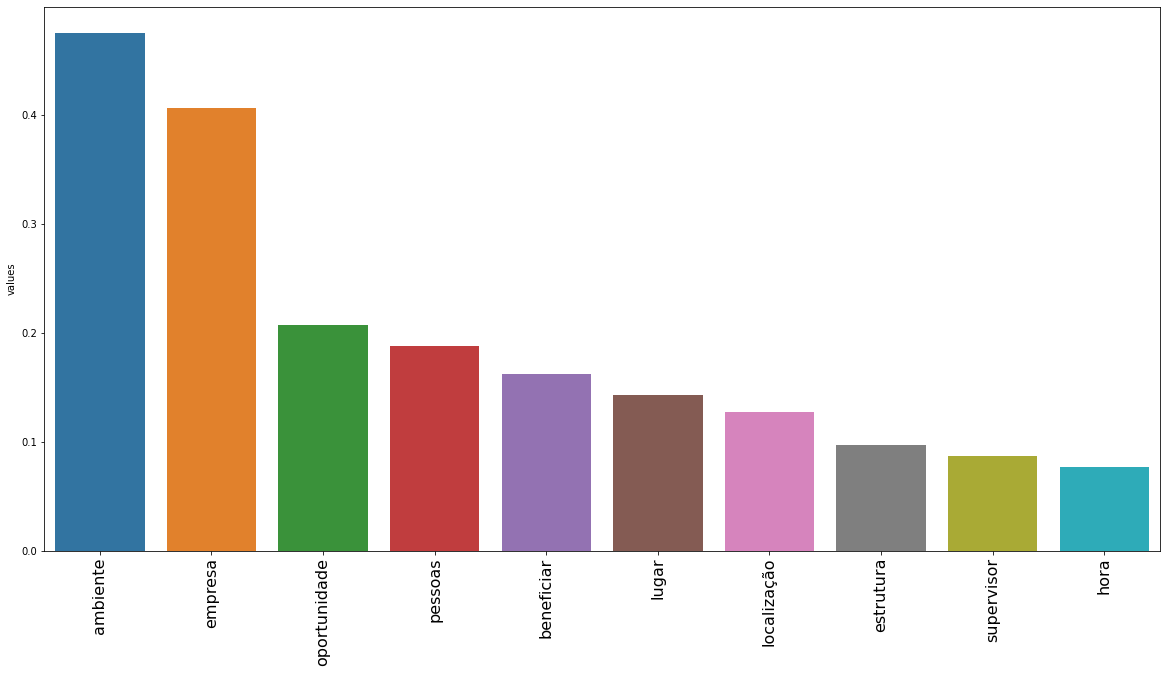

In [35]:
# Rankemento dos aspectos positivos
freq_aspects = df_positive_aspects.value_counts('aspect')
total = len(df_positive_aspects.value_counts('aspect'))

polarity_means = df_positive_aspects[['aspect','polarity']].groupby('aspect').mean()

#values = frequencia/total * mean(polaridade)
fxp_df = pd.DataFrame( { 'aspect': freq_aspects.keys(), 'frequencia': freq_aspects.values } )

#frequencia/total
fxp_df['f_t'] = fxp_df['frequencia'] / total

#values
fxp_df['values'] = fxp_df['f_t'] * [ polarity_means['polarity'][x] for x in freq_aspects.keys() ]


#Coletando top n
n = 10
topn_df = fxp_df[['aspect','values']].sort_values('values', ascending=False).head(10)

keys = topn_df['aspect']
values = abs(topn_df['values'])

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(x = [x.text.lower() for x in Translator().translate(list(keys), dest='pt_br')],y = values, ax = ax)
plt.xticks(rotation=90,fontsize=16)
plt.show()

fig.savefig("../Dashboard/assets/pos_asp_pond.png", bbox_inches='tight',pad_inches=0,format='png',dpi=1000)

## Analise de Rates

In [36]:
data

,pros,contras,rates,contras_en,pros_en,ttr_pros,ttr_contra,ttr_medio,ttr_normalized
0,"Salário pago sempre em dia, ótimos benefícios ...",Dificuldade em troca de turno.,"5,0",Difficulty in shift change.,"Salary paid on time, great benefits and opport...",2.236068,1.414214,1.825141,0.285798
1,Apenas 6 horas de serviço. Paga sempre na data...,Tem que passar por todo um stress pra consegui...,"5,0",You have to go through all the stress to be ab...,Only 6 hours of service. Always pay on the due...,2.236068,4.385928,3.310998,0.570754
2,A empresa te dá a chance de escolher o horário...,"Nada do que reclamar da liq. Ao contrário, só ...","5,0",Nothing to complain about liq. On the contrary...,The company gives you the chance to choose the...,2.886751,2.651650,2.769201,0.466849
3,Dar oportunidade de crescer na empresa,Surpervisores que gosta de oprimir o funcionario,"4,0",Supervisors who like to oppress the employee,Give opportunity to grow in the company,1.870829,1.870829,1.870829,0.294560
4,"Área de descontração, alimentação, local bem h...","Barulho no local de trabalho, fofocas.","4,0","Noise in the workplace, gossip.","Relaxation area, food, very hygienic place.",1.732051,1.581139,1.656595,0.253475
...,...,...,...,...,...,...,...,...,...
3435,Possui plano de saúde com padrões acima de out...,Por ser muito grande às vezes os processos e t...,"4,0","Because it is very large, sometimes the proces...",It has a health plan with standards above othe...,3.340766,4.142586,3.741676,0.653349
3436,"Experiência que levarei por toda vida, por tud...","mal remuneração, mal qualificação dos gestores...","2,0","poor remuneration, poor qualification of manag...",An experience that I will take with me for a l...,3.250000,2.041241,2.645621,0.443149
3437,sinto uma certa estilidade e segurança referen...,empresa que prega relacionamentos e comunicaça...,"2,0",company that preaches relationships and commun...,I feel a certain stability and security regard...,2.572479,2.969848,2.771164,0.467226
3438,paga em dia,"desconta demais, é muito desorganizada , onda ...","1,0","too much discount, very disorganized, where su...",pay on time,1.224745,3.240370,2.232558,0.363932


In [49]:
data['rates'] = [ x.replace(',','.') for x in data['rates'].values ]
data["rates"] = pd.to_numeric(data["rates"])
data['new_rate'] = data['rates'] * data['ttr_normalized']
data['new_rate'] = round(data['new_rate'], 0)

data

,pros,contras,rates,contras_en,pros_en,ttr_pros,ttr_contra,ttr_medio,ttr_normalized,new_rate
0,"Salário pago sempre em dia, ótimos benefícios ...",Dificuldade em troca de turno.,5.0,Difficulty in shift change.,"Salary paid on time, great benefits and opport...",2.236068,1.414214,1.825141,0.285798,1.0
1,Apenas 6 horas de serviço. Paga sempre na data...,Tem que passar por todo um stress pra consegui...,5.0,You have to go through all the stress to be ab...,Only 6 hours of service. Always pay on the due...,2.236068,4.385928,3.310998,0.570754,3.0
2,A empresa te dá a chance de escolher o horário...,"Nada do que reclamar da liq. Ao contrário, só ...",5.0,Nothing to complain about liq. On the contrary...,The company gives you the chance to choose the...,2.886751,2.651650,2.769201,0.466849,2.0
3,Dar oportunidade de crescer na empresa,Surpervisores que gosta de oprimir o funcionario,4.0,Supervisors who like to oppress the employee,Give opportunity to grow in the company,1.870829,1.870829,1.870829,0.294560,1.0
4,"Área de descontração, alimentação, local bem h...","Barulho no local de trabalho, fofocas.",4.0,"Noise in the workplace, gossip.","Relaxation area, food, very hygienic place.",1.732051,1.581139,1.656595,0.253475,1.0
...,...,...,...,...,...,...,...,...,...,...
3435,Possui plano de saúde com padrões acima de out...,Por ser muito grande às vezes os processos e t...,4.0,"Because it is very large, sometimes the proces...",It has a health plan with standards above othe...,3.340766,4.142586,3.741676,0.653349,3.0
3436,"Experiência que levarei por toda vida, por tud...","mal remuneração, mal qualificação dos gestores...",2.0,"poor remuneration, poor qualification of manag...",An experience that I will take with me for a l...,3.250000,2.041241,2.645621,0.443149,1.0
3437,sinto uma certa estilidade e segurança referen...,empresa que prega relacionamentos e comunicaça...,2.0,company that preaches relationships and commun...,I feel a certain stability and security regard...,2.572479,2.969848,2.771164,0.467226,1.0
3438,paga em dia,"desconta demais, é muito desorganizada , onda ...",1.0,"too much discount, very disorganized, where su...",pay on time,1.224745,3.240370,2.232558,0.363932,0.0


In [50]:
data.sort_values(by=['ttr_normalized'], ascending=False)


,pros,contras,rates,contras_en,pros_en,ttr_pros,ttr_contra,ttr_medio,ttr_normalized,new_rate
2069,A satisfação dentro da empresa depende do prod...,O principal problema dentro da empresa é a cob...,3.0,The main problem within the company is the ove...,Satisfaction within the company depends on the...,5.187884,5.910578,5.549231,1.000000,3.0
1741,"Contratam independente de raça, orientação sex...","Descontam cada minuto, mesmo que vc tenha cheg...",2.0,"They discount every minute, even if you arrive...","They hire regardless of race, sexual orientati...",3.556004,7.425668,5.490836,0.988801,2.0
1496,"Se garimpar tem excelentes profissionais, equi...","A gerência da empresa não é profissional, tudo...",2.0,"The company's management is not professional, ...","Garimpar has excellent professionals, mostly u...",3.243723,7.507043,5.375383,0.966660,2.0
3023,"O salário não atrasa, sempre está disponivel ...",A empresa abusa do pressão excessiva de superv...,1.0,The company abuses the excessive pressure of s...,"The salary does not delay, it is always availa...",2.743977,7.451828,5.097903,0.913445,1.0
1508,É boa para um primeiro emprego no mercado de t...,Eles não valorizam o atendente como deveriam. ...,3.0,They don't value the attendant as they should....,It's good for a first job in the job market. H...,4.461089,5.175492,4.818290,0.859821,3.0
...,...,...,...,...,...,...,...,...,...,...
3412,"Carga horaria, e trabalho em equipe.",A pressão. E as metas............,3.0,The pressure. And the goals............,Hours and teamwork.,1.224745,1.264911,1.244828,0.174507,1.0
841,"mais ou menos, bem mais ou menos",mais ok do que menos,2.0,more ok than less,"more or less, well more or less",1.069045,1.414214,1.241629,0.173893,0.0
2631,"Amizades, oportunidade de 1 emprego","Desvalorização, salários baixos.",3.0,"Devaluation, low wages.","Friendships, 1 job opportunity",1.224745,1.224745,1.224745,0.170655,1.0
3421,Legal como experiência,Dificuldade de oportunide,2.0,difficulty of opportunity,cool as experience,1.224745,1.224745,1.224745,0.170655,0.0


In [52]:
pond_rate = data['new_rate'].sum() / data['ttr_normalized'].sum()

print("RATE GERAL: ", round(pond_rate,1))

RATE GERAL:  3.1


In [55]:
print( "MEDIA DO NOVO RATE: " , round(data['rates'].mean(), 1) )

MEDIA DO NOVO RATE:  3.1


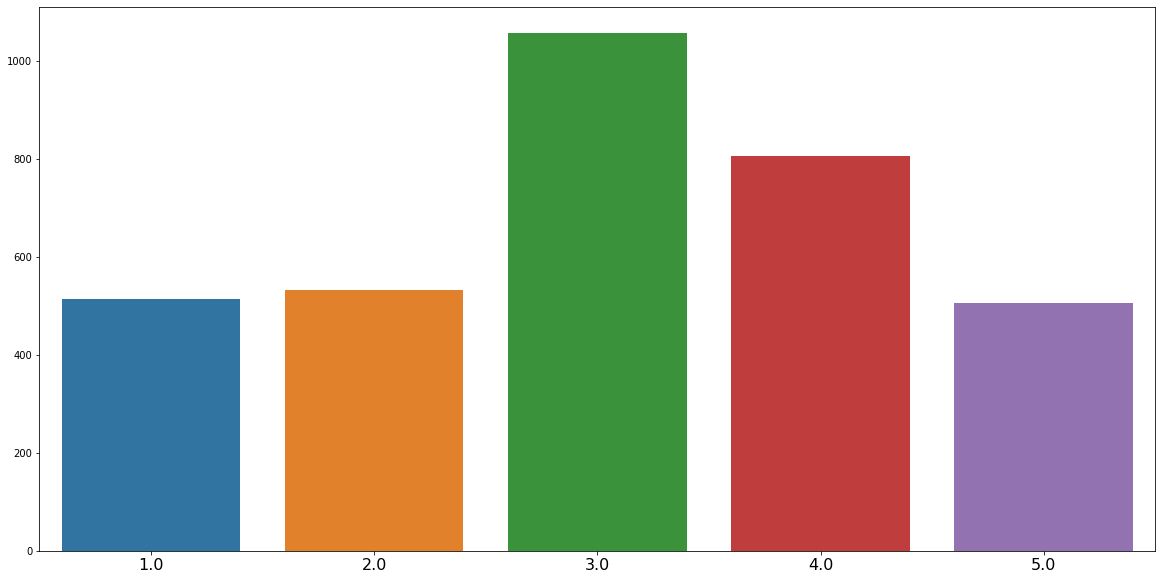

In [41]:
keys = data['rates'].value_counts().keys()
values = data['rates'].value_counts().values

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(x= keys,y =values, ax = ax)
plt.xticks(fontsize=16)
plt.show()

fig.savefig("../Dashboard/assets/rate.png", bbox_inches='tight',pad_inches=0,format='png',dpi=1000)

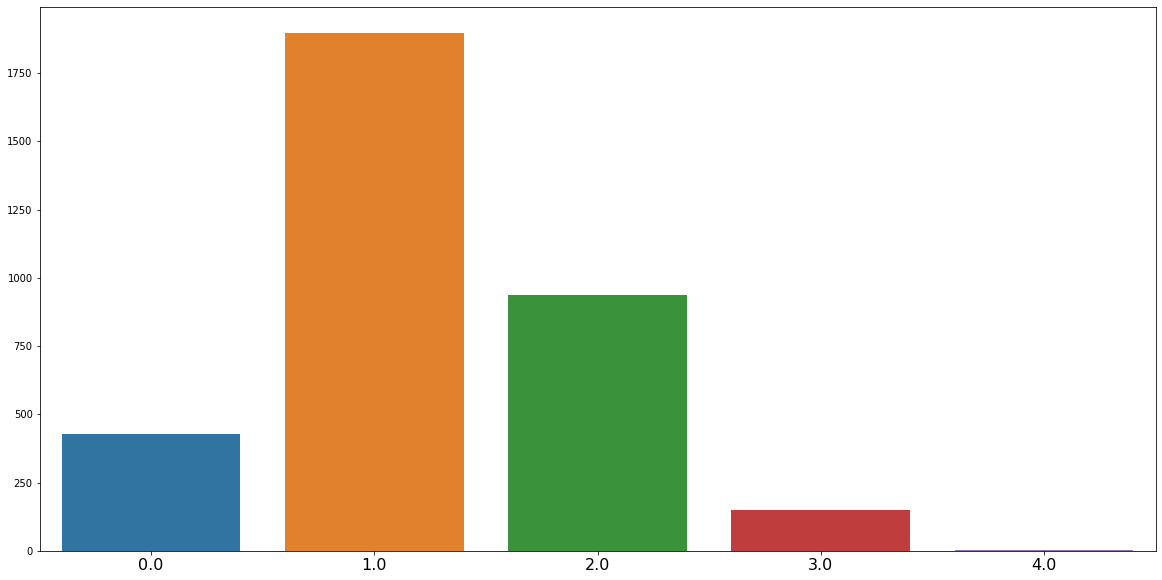

In [42]:
keys = data['new_rate'].value_counts().keys()
values = data['new_rate'].value_counts().values

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(x = keys,y = values,ax = ax)
plt.xticks(fontsize=16)
plt.show()

fig.savefig("../Dashboard/assets/new_rate.png", bbox_inches='tight',pad_inches=0,format='png',dpi=1000)